<a href="https://colab.research.google.com/github/yanli499/APS360-Project/blob/master/VGG_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# ALL import statements
import os
import shutil
import copy
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.autograd import Variable

In [26]:
# Mount our Google Drive
# re-run whenever needed
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# re-run when needed
# classes are folders in each directory with these names
classes = ['afraid','angry','disgusted','happy','neutral','sad','surprised']

# emotion label for KDEF photos
emotion_code = {"AF":"afraid", "AN":"angry", "DI":"disgusted", "HA":"happy", 
                "NE":"neutral", "SA":"sad", "SU":"surprised"}

data_dir='/content/drive/My Drive/Colab Notebooks/Faces'

In [28]:
# RUN ONLY ONCE!!!

# logic for sorting thru KDEF dataset for the images we want
"""
- eg file name: AF01ANFL.JPG
- Check:
    - length of name = 7, for straight profile only, ends with "S.jpg"
    - str[4:5] = {"AF":"afraid", "AN":"angry", "DI":"disgusted", "HA":"happy",
    "NE":"neutral", "SA":sad", "SU":"surprised"}
"""

# delete existing folder
if os.path.exists(data_dir+'/'):
    shutil.rmtree(data_dir+'/')

# make new directories for each emotion class + train, val, test
try:
    os.mkdir(data_dir)

    for i in range(len(classes)):
        os.mkdir(data_dir+'/'+classes[i])

    os.mkdir(data_dir+'/train')
    for i in range(len(classes)):
        os.mkdir(data_dir+'/train/'+classes[i])
    
    os.mkdir(data_dir+'/val')
    for i in range(len(classes)):
        os.mkdir(data_dir+'/val/'+classes[i])

    os.mkdir(data_dir+'/test')
    for i in range(len(classes)):
        os.mkdir(data_dir+'/test/'+classes[i])

except OSError:
    print ("Creation of the directories failed!")
else:
    print ("Successfully created the directories!")

# rootdir = path to KDEF main folder
rootdir = '/content/drive/My Drive/Colab Notebooks/PROJECT/KDEF/'

# go thru KDEF data + sort out desired photos
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filename = subdir + os.sep + file
        if (file.endswith("S.jpg") or file.endswith("S.JPG")): 
            # for each straight profile photo:
            # convert RGB --> Grayscale
            # resize to 256 x 256 pixels, b/c will center crop to 224 x 224 later
            # then save in the corresponding emotion class folder
            img = Image.open(filename).convert('L')
            new_img = img.resize((256, 256))

            if (file[4:6] == "AF"):
                new_img.save(data_dir+'/'+emotion_code["AF"]+'/'+file)
            elif (file[4:6] == "AN"):
                new_img.save(data_dir+'/'+emotion_code["AN"]+'/'+file)
            elif (file[4:6] == "DI"): 
                new_img.save(data_dir+'/'+emotion_code["DI"]+'/'+file)
            elif (file[4:6] == "HA"): 
                new_img.save(data_dir+'/'+emotion_code["HA"]+'/'+file)
            elif (file[4:6] == "NE"):
                new_img.save(data_dir+'/'+emotion_code["NE"]+'/'+file)
            elif (file[4:6] == "SA"): 
                new_img.save(data_dir+'/'+emotion_code["SA"]+'/'+file)
            elif (file[4:6] == "SU"):
                new_img.save(data_dir+'/'+emotion_code["SU"]+'/'+file)



Successfully created the directories!


In [0]:
# Split data into train, val, test datasets (60:20:20)
# each class = 140 images --> 84 train, 28 val, 28 test

# divide data into train, val, + test
# for each emotion class, get filenames, shuffle, 
# divide, move to corresponding folders in train, val, test
for c in classes:
    filepath = data_dir+'/'+c
    names = []

    for file in os.listdir(filepath):
        names.append(file)
    random.shuffle(names)

    # TODO: Can probably simplify this
    count = 0
    for name in names:
        if(count == 84):
            break
        else:
            # shutil.move(dir1, dir2) = moves file form directory 1 to directory 2
            shutil.move(filepath+'/'+name, data_dir+'/train/'+c+'/'+name)
            names.remove(name)
            count += 1

    count = 0
    for name in names:
        if(count == 28):
            break
        else:
            shutil.move(filepath+'/'+name, data_dir+'/val/'+c+'/'+name)
            names.remove(name)
            count += 1

    count = 0
    for name in names:
        if(count == 28):
            break
        else:
            shutil.move(filepath+'/'+name, data_dir+'/test/'+c+'/'+name)
            names.remove(name)
            count += 1

In [30]:
import torchvision.models

alexnet = torchvision.models.alexnet(pretrained=True)
vgg16 = torchvision.models.vgg16(pretrained=True)

torch.manual_seed(1) # set the random seed

classes = ['afraid','angry','disgusted','happy','neutral','sad','surprised']

data_dir='/content/drive/My Drive/Colab Notebooks/Faces/'

batch_size=1

# define training and test data directories
train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'val/')
test_dir = os.path.join(data_dir, 'test/')

data_transform = transforms.Compose([transforms.CenterCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)
    
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# delete existing folder
if os.path.exists(data_dir+'vgg16'):
    shutil.rmtree(data_dir+'vgg16')

try:
    os.mkdir(data_dir+'vgg16')

    os.mkdir(data_dir+'vgg16/train')
    for i in range(len(classes)):
        os.mkdir(data_dir+'vgg16/train/'+classes[i])
    
    os.mkdir(data_dir+'vgg16/val')
    for i in range(len(classes)):
        os.mkdir(data_dir+'vgg16/val/'+classes[i])

    os.mkdir(data_dir+'vgg16/test')
    for i in range(len(classes)):
        os.mkdir(data_dir+'vgg16/test/'+classes[i])

except OSError:
    print ("Creation of the directories failed!")
else:
    print ("Successfully created the directories!")


# delete existing folder
if os.path.exists(data_dir+'alexnet'):
    shutil.rmtree(data_dir+'alexnet')

try:
    os.mkdir(data_dir+'alexnet')

    os.mkdir(data_dir+'alexnet/train')
    for i in range(len(classes)):
        os.mkdir(data_dir+'alexnet/train/'+classes[i])
    
    os.mkdir(data_dir+'alexnet/val')
    for i in range(len(classes)):
        os.mkdir(data_dir+'alexnet/val/'+classes[i])

    os.mkdir(data_dir+'alexnet/test')
    for i in range(len(classes)):
        os.mkdir(data_dir+'alexnet/test/'+classes[i])

except OSError:
    print ("Creation of the directories failed!")
else:
    print ("Successfully created the directories!")



def save_tensor(dir_name, features, label, img_num):
  path='/content/drive/My Drive/Colab Notebooks/Faces/'+dir_name
  if (label.item() == 0):
    torch.save(features, path + '/afraid/features_' + str(img_num) + '.tensor')
  if (label.item() == 1):
    torch.save(features, path + '/angry/features_' + str(img_num) + '.tensor')
  if (label.item() == 2):
    torch.save(features, path + '/disgusted/features_' + str(img_num) + '.tensor')
  if (label.item() == 3):
    torch.save(features, path + '/happy/features_' + str(img_num) + '.tensor')
  if (label.item() == 4):
    torch.save(features, path + '/neutral/features_' + str(img_num) + '.tensor')
  if (label.item() == 5):
    torch.save(features, path + '/sad/features_' + str(img_num) + '.tensor')
  if (label.item() == 6):
    torch.save(features, path + '/surprised/features_' + str(img_num) + '.tensor')
  

i = 0
for img, label in train_loader:
    features = vgg16.features(img)
    save_tensor('vgg16/train', features, label, i)
    i+=1

i = 0
for img, label in val_loader:
    features = vgg16.features(img)
    save_tensor('vgg16/val', features, label, i)
    i+=1

i = 0
for img, label in test_loader:
    features = vgg16.features(img)
    save_tensor('vgg16/test', features, label, i)
    i+=1




i = 0
for img, label in train_loader:
    features = alexnet.features(img)
    save_tensor('alexnet/train', features, label, i)
    i+=1

i = 0
for img, label in val_loader:
    features = alexnet.features(img)
    save_tensor('alexnet/val', features, label, i)
    i+=1

i = 0
for img, label in test_loader:
    features = alexnet.features(img)
    save_tensor('alexnet/test', features, label, i)
    i+=1
    


Successfully created the directories!
Successfully created the directories!


In [0]:
#Artifical Neural Network Architecture
class ANNClassifier_Alexnet(nn.Module):
    def __init__(self):
        super(ANNClassifier_Alexnet, self).__init__()
        self.name = "alexnet_ann"
        self.fc1 = nn.Linear(256 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 7)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#Artifical Neural Network Architecture
class ANNClassifier_VGG16(nn.Module):
    def __init__(self):
        super(ANNClassifier_VGG16, self).__init__()
        self.name = "vgg16_ann"
        self.fc1 = nn.Linear(512*7*7, 32)
        self.fc2 = nn.Linear(32, 7)

    def forward(self, x):
        x = x.view(-1, 512*7*7) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
      
#output = model(features)
#prob = F.softmax(output)

In [0]:
def load_feature(loc): 
    return torch.load(loc)

# Data Loading
def get_data_loader(data_dir, batch_size):
  
    # mount our Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # define training and test data directories
    train_dir = os.path.join(data_dir, 'train/')
    val_dir = os.path.join(data_dir, 'val/')
    test_dir = os.path.join(data_dir, 'test/')

    # resize all images to 224 x 224
    #data_transform = transforms.Compose([transforms.CenterCrop(224), 
    #                                  transforms.ToTensor()])

    train_data = datasets.DatasetFolder(train_dir, loader = load_feature, extensions = '.tensor')
    val_data = datasets.DatasetFolder(val_dir, loader = load_feature, extensions = '.tensor')
    test_data = datasets.DatasetFolder(test_dir, loader = load_feature, extensions = '.tensor')

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader


# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path
  
def get_accuracy(model, loader):

    correct = 0
    total = 0
    for imgs, labels in loader:

        imgs = torch.from_numpy(imgs.detach().numpy())
        
        output = model(imgs)
        prob = F.softmax(output)
        
        #select index with maximum prediction score
        pred = prob.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
        
    return correct / total

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         acc: A scalar for the avg classification acc over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_epoch = 0
    correct = 0
    total = 0
    for i, data in enumerate(loader, 0):
        imgs, labels = data
        
        imgs = torch.from_numpy(imgs.detach().numpy())
              
        out = model(imgs)             # forward pass
        prob = F.softmax(out)
        loss = criterion(prob, labels)
        
        #select index with maximum prediction score
        pred = prob.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
        
        total_loss += loss
        total_epoch += len(labels)
    
    acc = correct / total
    loss = float(total_loss) / (i + 1)
    
    return acc, loss

# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation accuracy/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    
    n = len(train_acc) # number of epochs
    
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    
    plt.title("Train vs Validation Accuracy")
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/'):

    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader = get_data_loader(data_dir, batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_acc = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            
            # Get the inputs
            imgs, labels = data
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            imgs = torch.from_numpy(imgs.detach().numpy())
              
            out = model(imgs)             # forward pass
            prob = F.softmax(out)
            loss = criterion(prob, labels)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss
            total_epoch += len(labels)
        train_acc[epoch] = get_accuracy(net, train_loader)
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_acc[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
        
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    
    print('Finished Training')
    
    # Write the train/test loss/accuracy into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [0]:
# from lab 3b tutorial

import matplotlib.pyplot as plt

def get_accuracy_alexnet(model, loader):

    correct = 0
    total = 0
    for imgs, labels in loader:
        
        imgs = torch.from_numpy(imgs.detach().numpy())
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train(model, train_data, val_data, batch_size=20, num_epochs=1, learning_rate = 0.01):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            
            print(n)
            imgs = torch.from_numpy(imgs.detach().numpy())
              
            out = model(imgs)             # forward pass
            #prob = F.softmax(out)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy_alexnet(model, train_loader)) # compute training accuracy 
            val_acc.append(get_accuracy_alexnet(model, val_loader))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

#Artifical Neural Network Architecture
class ANNClassifier2(nn.Module):
    def __init__(self):
        super(ANNClassifier2, self).__init__()
        self.fc1 = nn.Linear(512*7*7, 32)
        self.fc2 = nn.Linear(32, 7)

    def forward(self, x):
        x = x.view(-1, 512*7*7) #flatten feature data
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

In [42]:
# mount our Google Drive
from google.colab import drive
drive.mount('/content/drive')

data_dir='/content/drive/My Drive/Colab Notebooks/Faces/alexnet/'

# classes are folders in each directory with these names
classes = ['afraid','angry','disgusted','happy','neutral','sad','surprised']

model = ANNClassifier_VGG16()
train_net(model, batch_size=64, learning_rate=0.01, num_epochs=30,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/vgg16')

model = ANNClassifier_VGG16()
train_net(model, batch_size=64, learning_rate=0.001, num_epochs=30,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/vgg16')

model = ANNClassifier_VGG16()
train_net(model, batch_size=128, learning_rate=0.01, num_epochs=30,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/vgg16')
  
model = ANNClassifier_Alexnet()
train_net(model, batch_size=64, learning_rate=0.01, num_epochs=30,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/alexnet')
  
model = ANNClassifier_Alexnet()
train_net(model, batch_size=128, learning_rate=0.01, num_epochs=30,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/alexnet')

model = ANNClassifier_Alexnet()
train_net(model, batch_size=64, learning_rate=0.001, num_epochs=30,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/alexnet')

model = ANNClassifier_Alexnet()
train_net(model, batch_size=64, learning_rate=0.01, num_epochs=75,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/alexnet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1: Train acc: 0.14285714285714285, Train loss: 1.9955722093582153 |Validation acc: 0.14285714285714285, Validation loss: 1.9655287265777588
Epoch 2: Train acc: 0.14489795918367346, Train loss: 1.9581784009933472 |Validation acc: 0.14285714285714285, Validation loss: 1.9466791152954102
Epoch 3: Train acc: 0.15510204081632653, Train loss: 1.945513367652893 |Validation acc: 0.15306122448979592, Validation loss: 1.944773554801941
Epoch 4: Train acc: 0.14489795918367346, Train loss: 1.9540824890136719 |Validation acc: 0.14285714285714285, Validation loss: 1.943448543548584
Epoch 5: Train acc: 0.24489795918367346, Train loss: 1.9422674179077148 |Validation acc: 0.2602040816326531, Validation loss: 1.9386857748031616
Epoch 6: Train acc: 0.23673469387755103, Train loss: 1.9394290447235107 |Validation acc: 0.22448979591836735, Validation loss: 1.9345970153808594
Epoch 7: Train acc: 0.2, Train loss: 1.9370783567428589 |Validation acc: 0.19387755102040816, Validation loss: 1.930450439453125

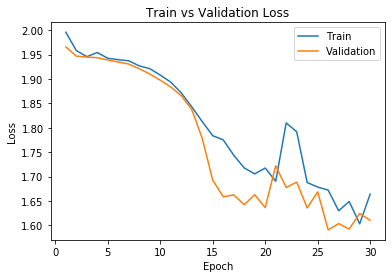

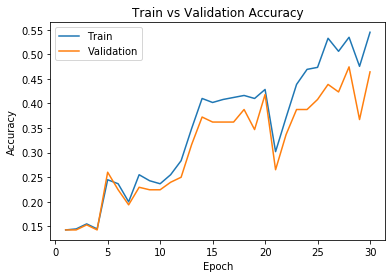

Final Training Accuracy: 0.5448979591836735
Final Validation Accuracy: 0.4642857142857143


In [44]:
model_path = get_model_name("vgg16_ann", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve('/content/' + model_path)

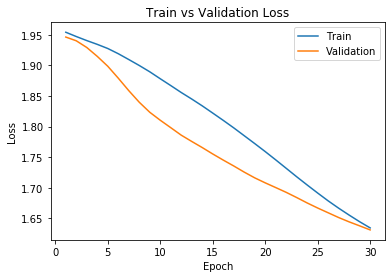

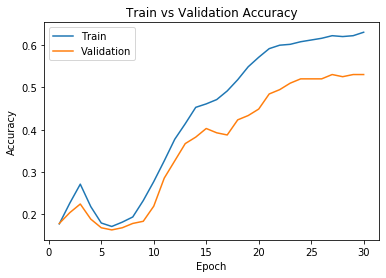

Final Training Accuracy: 0.6306122448979592
Final Validation Accuracy: 0.5306122448979592


In [45]:
model_path = get_model_name("vgg16_ann", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve('/content/' + model_path)

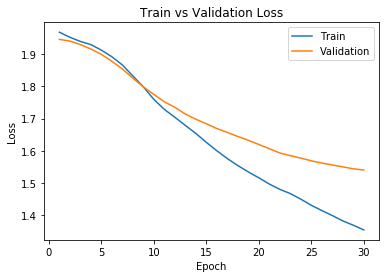

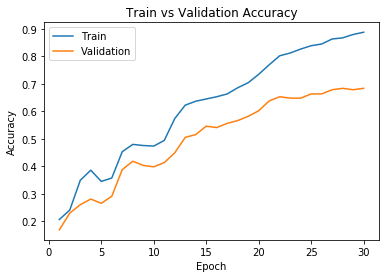

Final Training Accuracy: 0.8877551020408163
Final Validation Accuracy: 0.6836734693877551


In [46]:
model_path = get_model_name("vgg16_ann", batch_size=128, learning_rate=0.01, epoch=29)
plot_training_curve('/content/' + model_path)

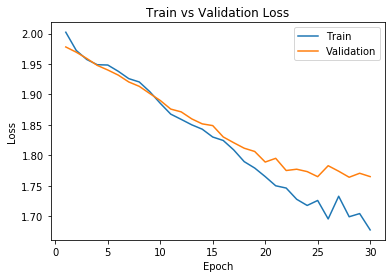

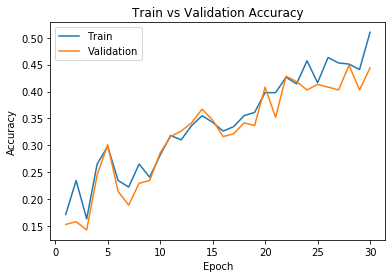

Final Training Accuracy: 0.5102040816326531
Final Validation Accuracy: 0.44387755102040816


In [47]:
model_path = get_model_name("alexnet_ann", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve('/content/' + model_path)

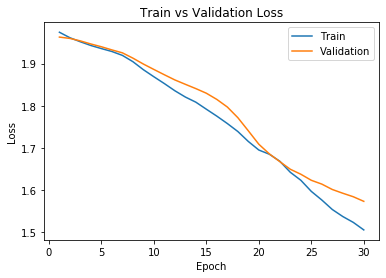

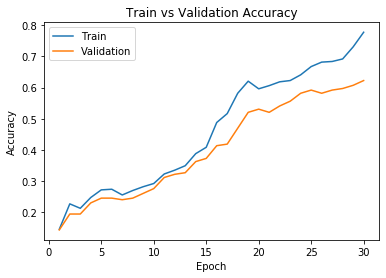

Final Training Accuracy: 0.7775510204081633
Final Validation Accuracy: 0.6224489795918368


In [48]:
model_path = get_model_name("alexnet_ann", batch_size=128, learning_rate=0.01, epoch=29)
plot_training_curve('/content/' + model_path)

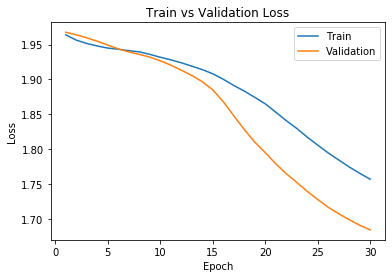

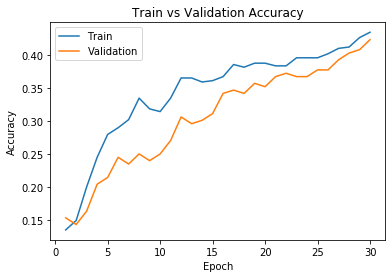

Final Training Accuracy: 0.4346938775510204
Final Validation Accuracy: 0.42346938775510207


In [49]:
model_path = get_model_name("alexnet_ann", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve('/content/' + model_path)

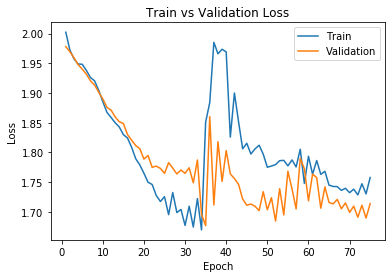

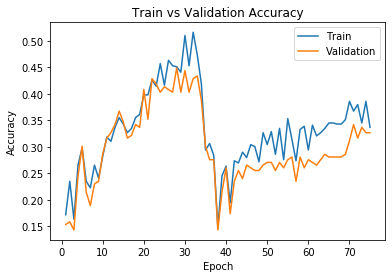

Final Training Accuracy: 0.336734693877551
Final Validation Accuracy: 0.32653061224489793


In [50]:
model_path = get_model_name("alexnet_ann", batch_size=64, learning_rate=0.01, epoch=74)
plot_training_curve('/content/' + model_path)

In [51]:
model = ANNClassifier_VGG16()
train_net(model, batch_size=128, learning_rate=0.01, num_epochs=50,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/vgg16')

model = ANNClassifier_Alexnet()
train_net(model, batch_size=128, learning_rate=0.01, num_epochs=50,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/alexnet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1: Train acc: 0.1510204081632653, Train loss: 1.9599988460540771 |Validation acc: 0.15306122448979592, Validation loss: 1.9460155963897705
Epoch 2: Train acc: 0.22244897959183674, Train loss: 1.9471869468688965 |Validation acc: 0.16326530612244897, Validation loss: 1.9415583610534668
Epoch 3: Train acc: 0.21428571428571427, Train loss: 1.9415242671966553 |Validation acc: 0.15816326530612246, Validation loss: 1.9373611211776733
Epoch 4: Train acc: 0.3346938775510204, Train loss: 1.93669855594635 |Validation acc: 0.22448979591836735, Validation loss: 1.9325841665267944
Epoch 5: Train acc: 0.3693877551020408, Train loss: 1.9302119016647339 |Validation acc: 0.2602040816326531, Validation loss: 1.9264349937438965
Epoch 6: Train acc: 0.36122448979591837, Train loss: 1.9203128814697266 |Validation acc: 0.27040816326530615, Validation loss: 1.9182708263397217
Epoch 7: Train acc: 0.4530612244897959, Train loss: 1.90919828414917 |Validation acc: 0.336734693877551, Validation loss: 1.909354

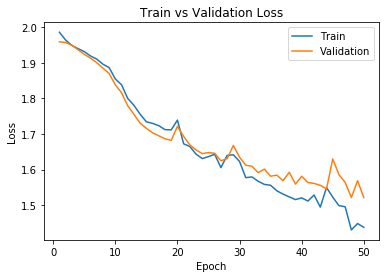

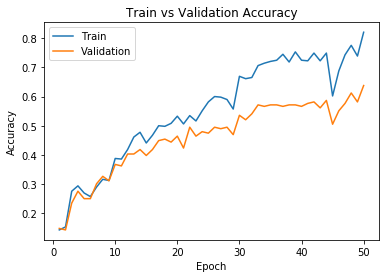

Final Training Accuracy: 0.8204081632653061
Final Validation Accuracy: 0.6377551020408163


In [52]:
model_path = get_model_name("alexnet_ann", batch_size=128, learning_rate=0.01, epoch=49)
plot_training_curve('/content/' + model_path)

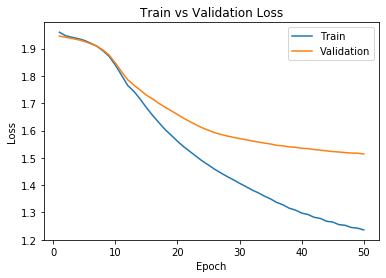

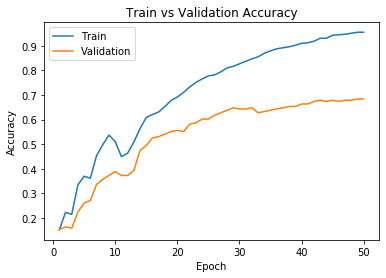

Final Training Accuracy: 0.9551020408163265
Final Validation Accuracy: 0.6836734693877551


In [53]:
model_path = get_model_name("vgg16_ann", batch_size=128, learning_rate=0.01, epoch=49)
plot_training_curve('/content/' + model_path)

In [54]:
model = ANNClassifier_Alexnet()
train_net(model, batch_size=128, learning_rate=0.01, num_epochs=75,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/alexnet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1: Train acc: 0.14285714285714285, Train loss: 1.985783338546753 |Validation acc: 0.14795918367346939, Validation loss: 1.9590446949005127
Epoch 2: Train acc: 0.15306122448979592, Train loss: 1.9638559818267822 |Validation acc: 0.14285714285714285, Validation loss: 1.956953525543213
Epoch 3: Train acc: 0.2755102040816326, Train loss: 1.9487744569778442 |Validation acc: 0.23469387755102042, Validation loss: 1.9493101835250854
Epoch 4: Train acc: 0.2938775510204082, Train loss: 1.9397027492523193 |Validation acc: 0.2755102040816326, Validation loss: 1.9365719556808472
Epoch 5: Train acc: 0.2693877551020408, Train loss: 1.9314241409301758 |Validation acc: 0.25, Validation loss: 1.9236209392547607
Epoch 6: Train acc: 0.2571428571428571, Train loss: 1.919215440750122 |Validation acc: 0.25, Validation loss: 1.9131226539611816
Epoch 7: Train acc: 0.2897959183673469, Train loss: 1.9104723930358887 |Validation acc: 0.3010204081632653, Validation loss: 1.9004579782485962
Epoch 8: Train acc

In [56]:
model = ANNClassifier_VGG16()
train_net(model, batch_size=128, learning_rate=0.01, num_epochs=75,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/vgg16')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1: Train acc: 0.1510204081632653, Train loss: 1.9599988460540771 |Validation acc: 0.15306122448979592, Validation loss: 1.9460155963897705
Epoch 2: Train acc: 0.22244897959183674, Train loss: 1.9471869468688965 |Validation acc: 0.16326530612244897, Validation loss: 1.9415583610534668
Epoch 3: Train acc: 0.21428571428571427, Train loss: 1.9415242671966553 |Validation acc: 0.15816326530612246, Validation loss: 1.9373611211776733
Epoch 4: Train acc: 0.3346938775510204, Train loss: 1.93669855594635 |Validation acc: 0.22448979591836735, Validation loss: 1.9325841665267944
Epoch 5: Train acc: 0.3693877551020408, Train loss: 1.9302119016647339 |Validation acc: 0.2602040816326531, Validation loss: 1.9264349937438965
Epoch 6: Train acc: 0.36122448979591837, Train loss: 1.9203128814697266 |Validation acc: 0.27040816326530615, Validation loss: 1.9182708263397217
Epoch 7: Train acc: 0.4530612244897959, Train loss: 1.90919828414917 |Validation acc: 0.336734693877551, Validation loss: 1.909354

In [58]:
model = ANNClassifier_Alexnet()
train_net(model, batch_size=128, learning_rate=0.01, num_epochs=100,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/alexnet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1: Train acc: 0.19591836734693877, Train loss: 1.9737696647644043 |Validation acc: 0.17857142857142858, Validation loss: 1.953268051147461
Epoch 2: Train acc: 0.1489795918367347, Train loss: 1.9525660276412964 |Validation acc: 0.14795918367346939, Validation loss: 1.943724274635315
Epoch 3: Train acc: 0.1510204081632653, Train loss: 1.9456102848052979 |Validation acc: 0.15306122448979592, Validation loss: 1.9356768131256104
Epoch 4: Train acc: 0.22857142857142856, Train loss: 1.9385555982589722 |Validation acc: 0.19387755102040816, Validation loss: 1.9270899295806885
Epoch 5: Train acc: 0.26326530612244897, Train loss: 1.9310595989227295 |Validation acc: 0.2193877551020408, Validation loss: 1.9218177795410156
Epoch 6: Train acc: 0.2795918367346939, Train loss: 1.9140413999557495 |Validation acc: 0.25, Validation loss: 1.9091410636901855
Epoch 7: Train acc: 0.3448979591836735, Train loss: 1.9027526378631592 |Validation acc: 0.3469387755102041, Validation loss: 1.8962881565093994
E

In [65]:
model = ANNClassifier_VGG16()
train_net(model, batch_size=128, learning_rate=0.01, num_epochs=100,
    data_dir='/content/drive/My Drive/Colab Notebooks/Faces/vgg16')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1: Train acc: 0.14489795918367346, Train loss: 1.965368390083313 |Validation acc: 0.16326530612244897, Validation loss: 1.9471402168273926
Epoch 2: Train acc: 0.22857142857142856, Train loss: 1.9497952461242676 |Validation acc: 0.1836734693877551, Validation loss: 1.9432556629180908
Epoch 3: Train acc: 0.3346938775510204, Train loss: 1.940274953842163 |Validation acc: 0.28061224489795916, Validation loss: 1.9326035976409912
Epoch 4: Train acc: 0.373469387755102, Train loss: 1.9284642934799194 |Validation acc: 0.336734693877551, Validation loss: 1.9205772876739502
Epoch 5: Train acc: 0.35714285714285715, Train loss: 1.9090429544448853 |Validation acc: 0.3163265306122449, Validation loss: 1.9036023616790771
Epoch 6: Train acc: 0.3836734693877551, Train loss: 1.8873567581176758 |Validation acc: 0.336734693877551, Validation loss: 1.878909707069397
Epoch 7: Train acc: 0.4020408163265306, Train loss: 1.8555978536605835 |Validation acc: 0.34183673469387754, Validation loss: 1.850598573

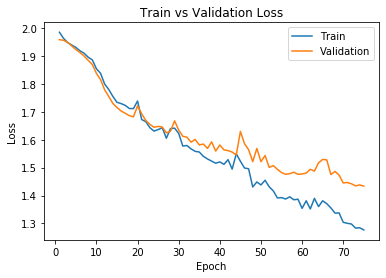

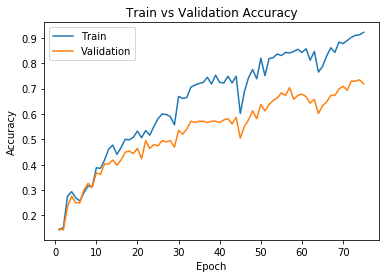

Final Training Accuracy: 0.9224489795918367
Final Validation Accuracy: 0.7193877551020408


In [55]:
model_path = get_model_name("alexnet_ann", batch_size=128, learning_rate=0.01, epoch=74)
plot_training_curve('/content/' + model_path)

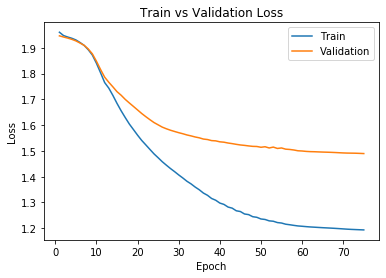

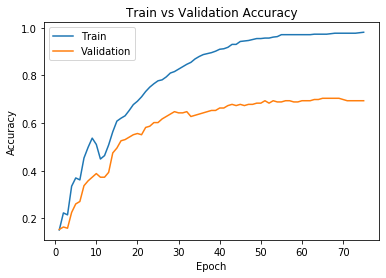

Final Training Accuracy: 0.9816326530612245
Final Validation Accuracy: 0.6938775510204082


In [57]:
model_path = get_model_name("vgg16_ann", batch_size=128, learning_rate=0.01, epoch=74)
plot_training_curve('/content/' + model_path)

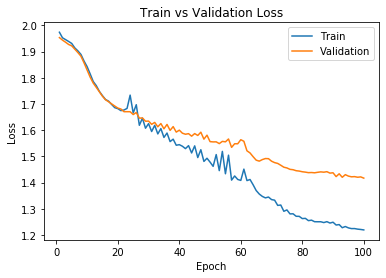

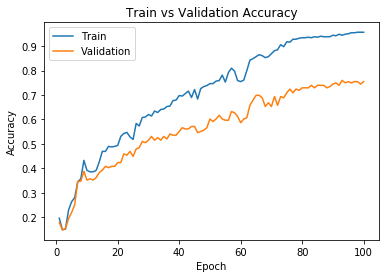

Final Training Accuracy: 0.9571428571428572
Final Validation Accuracy: 0.7551020408163265


In [59]:
model_path = get_model_name("alexnet_ann", batch_size=128, learning_rate=0.01, epoch=99)
plot_training_curve('/content/' + model_path)

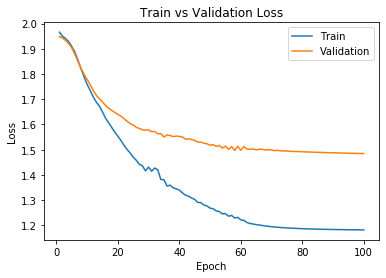

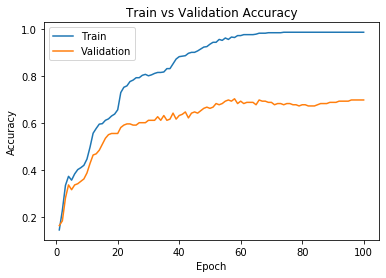

Final Training Accuracy: 0.9877551020408163
Final Validation Accuracy: 0.6989795918367347


In [67]:
model_path = get_model_name("vgg16_ann", batch_size=128, learning_rate=0.01, epoch=99)
plot_training_curve('/content/' + model_path)

In [63]:
model = ANNClassifier_Alexnet()
    
model_path = get_model_name("alexnet_ann", batch_size=128, learning_rate=0.01, epoch=99)
state = torch.load('/content/' + model_path)
model.load_state_dict(state)

data_dir='/content/drive/My Drive/Colab Notebooks/Faces/alexnet'

train_loader, val_loader, test_loader = get_data_loader(data_dir=data_dir, 
    batch_size=128)

criterion = nn.CrossEntropyLoss()
test_acc, test_loss = evaluate(model, test_loader, criterion)
print("Test classification accuracy:", test_acc)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Test classification accuracy: 0.7687074829931972


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
